# Dataset
This notebook will cover pretraining transformers on a custom dataset. I will use the well known movies reviews positive - negative labeled [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/).

The description provided on the Stanford website:

*This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well. Raw text and already processed bag of words formats are provided. See the README file contained in the release for more details.*

In [ ]:
# download the dataset
!wget -q -nc http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# unzip it
!tar -zxf /content/aclImdb_v1.tar.gz

In [ ]:
# setup env
!pip install ml-things transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 17.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 5.7 MB/s eta 0:00:00


## Import Library

In [ ]:
import io
import os
import torch
from torch.optim import AdamW
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

import warnings
from torch import manual_seed
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes


In [ ]:
# Set seed for reproducibility.
manual_seed(123)

# Number of training epochs (authors on fine-tuning Bert recommend between 2 and 4).
epochs = 4

# Number of batches - depending on the max sequence length and GPU memory.
# For 512 sequence length batch of 10 works without cuda memory issues.
# For small sequence length can try batch of 32 or higher.
batch_size = 32

# Pad or truncate text sequences to a specific length
# if `None` it will use maximum sequence of word piece tokens allowed by model.
max_length = 60

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Name of transformers model - will use already pretrained model.
# Path of transformer model - will load your own model from local disk.
model_name_or_path = 'gpt2'

# Dictionary of labels and their id - this will be used to convert.
# String labels to number ids.
labels_ids = {'neg': 0, 'pos': 1}

# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = len(labels_ids)

In [ ]:
file_path = "/content/aclImdb/test/neg/10000_4.txt"

with open(file_path, mode="r") as file:
    content = file.read()
    # Lakukan sesuatu dengan kontennya, misalnya print atau proses lebih lanjut
    print(content)


This is an example of why the majority of action films are the same. Generic and boring, there's really nothing worth watching here. A complete waste of the then barely-tapped talents of Ice-T and Ice Cube, who've each proven many times over that they are capable of acting, and acting well. Don't bother with this one, go see New Jack City, Ricochet or watch New York Undercover for Ice-T, or Boyz n the Hood, Higher Learning or Friday for Ice Cube and see the real deal. Ice-T's horribly cliched dialogue alone makes this film grate at the teeth, and I'm still wondering what the heck Bill Paxton was doing in this film? And why the heck does he always play the exact same character? From Aliens onward, every film I've seen with Bill Paxton has him playing the exact same irritating character, and at least in Aliens his character died, which made it somewhat gratifying...<br /><br />Overall, this is second-rate action trash. There are countless better films to see, and if you really want to se

In [ ]:
class MovieReviewDataset(Dataset):
    def __init__(self, path, use_tokenizer):
        if not os.path.isdir(path):
            raise ValueError('Invalid `path` variable! Needs to be a directory')
        self.texts = []
        self.labels = []
        # Since the labels are defined by folders with data we loop
        # through each label.
        for label in ['pos', 'neg']:
            sentiment_path = os.path.join(path, label)

            # Get all files from path.
            files_names = os.listdir(sentiment_path)#[:10] # Sample for debugging.
            # Go through each file and read its content.
            for file_name in tqdm(files_names, desc=f'{label} files'):
                file_path = os.path.join(sentiment_path, file_name)

                # Read content.
                content = io.open(file_path, mode='r', encoding='utf-8').read()
                # Fix any unicode issues.
                content = fix_text(content)
                # Save content.
                self.texts.append(content)
                # Save encode labels.
                self.labels.append(label)
        self.n_examples = len(self.labels)

    def __len__(self):
        return self.n_examples

    def __getitem__(self, item):
        return {
            'text':self.texts[item],
            'label':self.labels[item]
        }


In [ ]:
class Gpt2ClassificationCollator(object):

    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):
        # Tokenizer yang digunakan di dalam kelas.
        self.use_tokenizer = use_tokenizer
        # Periksa panjang maksimum urutan.
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        # Encoder label yang digunakan di dalam kelas.
        self.labels_encoder = labels_encoder

    def __call__(self, sequences):
        # Ambil semua teks dari daftar urutan.
        texts = [sequence['text'] for sequence in sequences]
        # Ambil semua label dari daftar urutan.
        labels = [sequence['label'] for sequence in sequences]
        # Encode semua label menggunakan label encoder.
        labels = [self.labels_encoder[label] for label in labels]
        # Panggil tokenizer pada semua teks untuk mengonversi menjadi tensor angka dengan padding yang sesuai.
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        # Perbarui input dengan label yang terkait sebagai tensor.
        inputs.update({'labels': torch.tensor(labels)})

        return inputs


In [ ]:
def train(dataloader, optimizer_, scheduler_, device_):
    """
  Train pytorch model on a single pass through the data loader.

  It will use the global variable `model` which is the transformer model
  loaded on `_device` that we want to train on.

  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed
    straight into the model - `model(**batch)`.

  Arguments:

      dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.

      optimizer_ (:obj:`transformers.optimization.AdamW`):
          Optimizer used for training.

      scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
          PyTorch scheduler.

      device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.

  Returns:

      :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss].
  """
    # Use global variable for model.
    global model

    # Tracking variables.
    predictions_labels = []
    true_labels = []
    # Total loss for this epoch.
    total_loss = 0

    # Put the model into training mode.
    model.train()

    # For each batch of training data...
    for batch in tqdm(dataloader, total=len(dataloader)):

        # Add original labels - use later for evaluation.
        true_labels += batch['labels'].numpy().flatten().tolist()

        # Move batch to device
        for key, value in batch.items():
            batch[key] = value.type(torch.long).to(device_)

        # Always clear any previously calculated gradients before performing a
        # backward pass.
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this a bert model function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull the
        # loss value out of the tuple along with the logits. We will use logits
        # later to calculate training accuracy.
        loss, logits = outputs[:2]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer_.step()

        # Update the learning rate.
        scheduler_.step()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Convert these logits to list of predicted labels values.
        predictions_labels += logits.argmax(axis=-1).flatten().tolist()

    # Calculate the average loss over the training data.
    avg_epoch_loss = total_loss / len(dataloader)

    # Return all true labels and prediction for future evaluations.
    return true_labels, predictions_labels, avg_epoch_loss


In [ ]:
def validation(dataloader, device_):
    # Use global variable for model.
    global model

    # Tracking variables
    predictions_labels = []
    true_labels = []
    #total loss for this epoch.
    total_loss = 0

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Evaluate data for one epoch
    for batch in tqdm(dataloader, total=len(dataloader)):
        # add original labels
        true_labels += batch['labels'].numpy().flatten().tolist()

        # Move batch to device
        for key, value in batch.items():
            batch[key] = value.type(torch.long).to(device_)

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(**batch)

            # The call to `model` always returns a tuple, so we need to pull the
            # loss value out of the tuple along with the logits. We will use logits
            # later to to calculate training accuracy.
            loss, logits = outputs[:2]

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()

            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value
            # from the tensor.
            total_loss += loss.item()

            # get predicitons to list
            predict_content = logits.argmax(axis=-1).flatten().tolist()

            # update list
            predictions_labels += predict_content

      # Calculate the average loss over the training data.
    avg_epoch_loss = total_loss / len(dataloader)

      # Return all true labels and prediciton for future evaluations.
    return true_labels, predictions_labels, avg_epoch_loss

## Load Model Tokenizer
In creating the model_config I will mention the number of labels I need for my classification task. Since I only predict two sentiments: positive and negative I will only need two labels for num_labels.

Creating the tokenizer is pretty standard when using the Transformers library. After creating the tokenizer it is critical for this tutorial to set padding to the left tokenizer.padding_side = "left" and initialize the padding token to tokenizer.eos_token which is the GPT2's original end of sequence token. This is the most essential part of this tutorial since GPT2 uses the last token for prediction so we need to pad to the left.

HuggingFace already did most of the work for us and added a classification layer to the GPT2 model. In creating the model I used GPT2ForSequenceClassification. Since we have a custom padding token we need to initialize it for the model using model.config.pad_token_id. Finally we will need to move the model to the device we defined earlier.

In [ ]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token


Loading configuraiton...


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Loading tokenizer...


vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
# Get the actual model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

Loading model...


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


In [ ]:
# Create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer,
                                                          labels_encoder=labels_ids,
                                                          max_sequence_len=max_length)


print('Dealing with Train...')
# Create pytorch dataset.
train_dataset = MovieReviewDataset(path='/content/aclImdb/train',
                               use_tokenizer=tokenizer)
print('Created `train_dataset` with %d examples!'%len(train_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches!'%len(train_dataloader))

print()

print('Dealing with Validation...')
# Create pytorch dataset.
valid_dataset =  MovieReviewDataset(path='/content/aclImdb/test',
                               use_tokenizer=tokenizer)
print('Created `valid_dataset` with %d examples!'%len(valid_dataset))

# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches!'%len(valid_dataloader))

Dealing with Train...


pos files:   0%|          | 0/12500 [00:00<?, ?it/s]

neg files:   0%|          | 0/12500 [00:00<?, ?it/s]

Created `train_dataset` with 25000 examples!
Created `train_dataloader` with 782 batches!

Dealing with Validation...


pos files:   0%|          | 0/12500 [00:00<?, ?it/s]

neg files:   0%|          | 0/12500 [00:00<?, ?it/s]

Created `valid_dataset` with 25000 examples!
Created `eval_dataloader` with 782 batches!


TRAINING . . .


  0%|          | 0/4 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/782 [00:00<?, ?it/s]

  train_loss: 0.47186 - val_loss: 0.38820 - train_acc: 0.76264 - valid_acc: 0.81416


Training on batches...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/782 [00:00<?, ?it/s]

  train_loss: 0.35848 - val_loss: 0.36713 - train_acc: 0.83888 - valid_acc: 0.83272


Training on batches...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/782 [00:00<?, ?it/s]

  train_loss: 0.30392 - val_loss: 0.37192 - train_acc: 0.86768 - valid_acc: 0.83216


Training on batches...


  0%|          | 0/782 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/782 [00:00<?, ?it/s]

  train_loss: 0.26476 - val_loss: 0.38762 - train_acc: 0.88696 - valid_acc: 0.83456



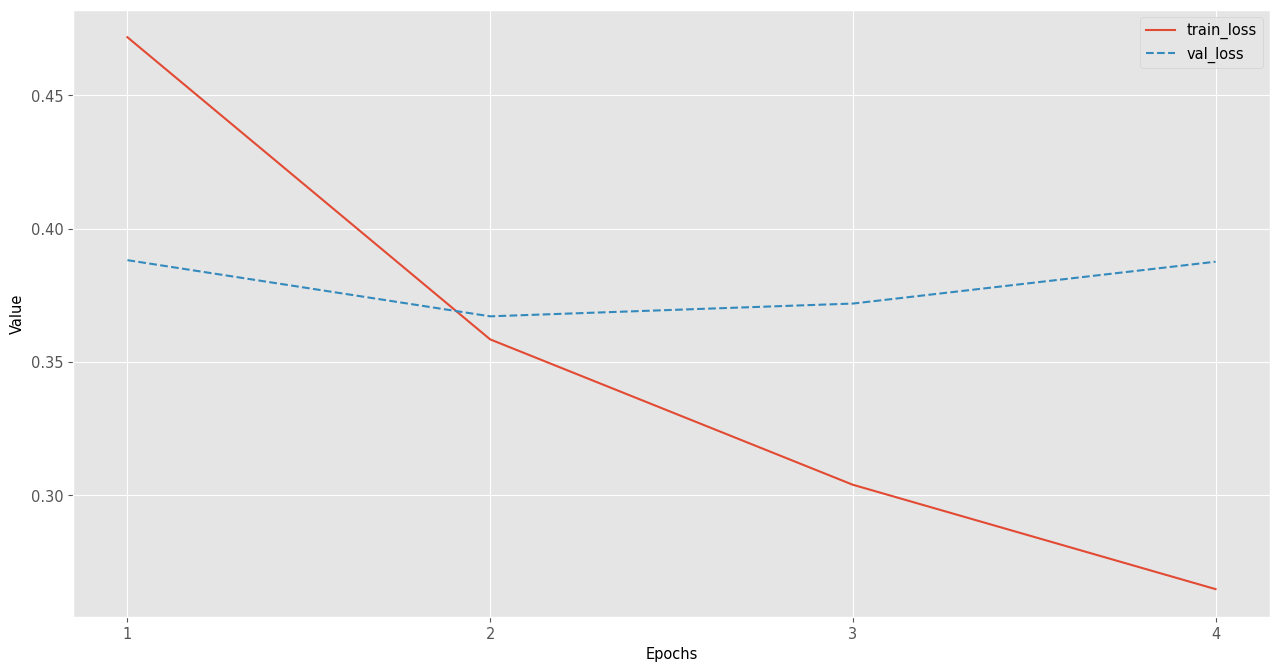

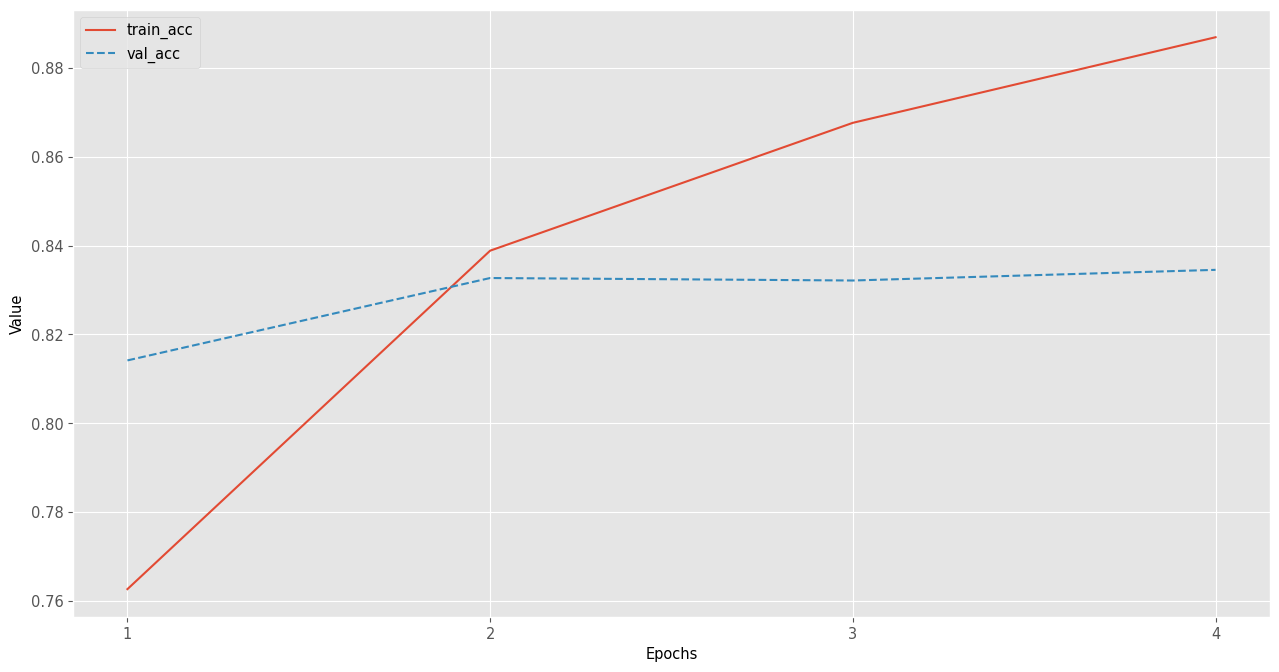

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # default is 1e-8.
                  )

# Total number of training steps is number of batches * number of epochs.
# `train_dataloader` contains batched data so `len(train_dataloader)` gives
# us the number of batches.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('TRAINING . . .')
for epoch in tqdm(range(epochs)):
    print()
    print('Training on batches...')
    # Perform one full pass over the training set.
    train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
    train_acc = accuracy_score(train_labels, train_predict)

    # Get prediction form model on validation data.
    print('Validation on batches...')
    valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
    val_acc = accuracy_score(valid_labels, valid_predict)

    # Print loss and accuracy values to see how training evolves.
    print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
    print()

    # Store the loss value for plotting the learning curve.
    all_loss['train_loss'].append(train_loss)
    all_loss['val_loss'].append(val_loss)
    all_acc['train_acc'].append(train_acc)
    all_acc['val_acc'].append(val_acc)

# Plot loss curves.
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

# Plot accuracy curves.
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

  0%|          | 0/782 [00:00<?, ?it/s]

              precision    recall  f1-score   support

         neg       0.84      0.83      0.83     12500
         pos       0.83      0.84      0.84     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000

Normalized confusion matrix


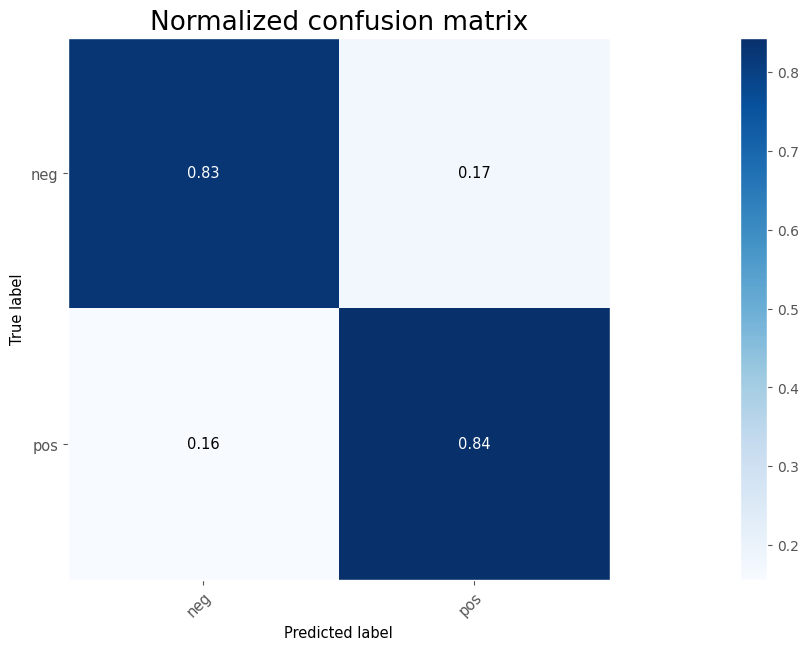

In [ ]:

# Get prediction form model on validation data. This is where you should use
# your test data.
true_labels, predictions_labels, avg_epoch_loss = validation(valid_dataloader, device)

# Create the evaluation report.
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()))
# Show the evaluation report.
print(evaluation_report)

# Plot confusion matrix.
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels,
                      classes=list(labels_ids.keys()), normalize=True,
                      magnify=0.1,
                      );